In [30]:
using DrWatson
@quickactivate projectdir()

In [31]:
include(srcdir("rdpg.jl"))
import Main.rdpg
using PersistenceDiagrams, Pipe, Plots, ProgressMeter, Random, Ripserer, Statistics, StatsBase
using Distributions, LinearAlgebra, UMAP
using ProgressMeter
using Random

In [56]:
# function scale_embeddings(X)
#     return StatsBase.standardize(ZScoreTransform, X, dims=1)
# end

function scale_embeddings(X)
    c = cov(X)
    U = eigvecs(c)
    s = U * Diagonal(eigvals(c) .^ -0.5) * transpose(U)
    return X * s
end

function diagram(X; dim_max)
    dgm = ripserer(X |> Alpha, dim_max=dim_max)
    [replace(x -> death(x) == Inf ? PersistenceInterval(birth(x), threshold(d)) : x, d) for d in dgm]
end

function bottleneck_distances(X, Y, dim_max)
    DX = diagram(X, dim_max)
    DY = diagram(Y, dim_max)
    return [Bottleneck()(DX[d], DY[d]) for d in 1:dim_max+1]
end

function bottleneck_distance(Dx, Dy; order=nothing, p=Inf)
    order = isnothing(order) ? 0 : order
    dx, dy = Dx[1+order], Dy[1+order]
    m = max(0, min(length.((dx, dy))...) .- 1)
    dx = dx[end-m:end]
    dy = dy[end-m:end]
    return norm(map((x, y) -> (x .- y) .|> abs |> maximum, dx, dy), p)
end

function subsample(X, a=0.75)
    sample(X |> rdpg.m2t, round(Int, size(X, 1)^a), replace=false)
end

function generate_graph(n; k=3, r=0.1, p=0.7)
    Z = rand(1:k, n)
    f = (x, y) -> r + p * (x == y)
    return rdpg.Adjacency(f, Z)
end



generate_graph (generic function with 1 method)

In [62]:
repeats = 10
N = [500, 1_000, 5_000]
ϵ = [1:1:10...]
max_dim = 1
d = 2
order = 1;

In [63]:
n = length(ϵ)

with_eps = [zeros(repeats, n) for _ in eachindex(Ns)];
without_eps = [zeros(repeats, n) for _ in eachindex(Ns)];
prog = Progress(convert(Int, n * repeats * length(Ns)))

for i in eachindex(N)
    Random.seed!(2022)
    A = generate_graph(N[i])
    
    X, _, _ = rdpg.spectralEmbed(A, d=d)
    DX = diagram(X |> subsample, dim_max=order)
    
    X_norm = scale_embeddings(X)
    DX_norm = diagram(X_norm |> subsample, dim_max=order)
    

    for j in eachindex(ϵ), k in 1:repeats

        A1 = rdpg.edgeFlip(A, ϵ=ϵ[j])
        X1, _ = rdpg.spectralEmbed(A1, d=d)
        X1_norm = scale_embeddings(X1)
        D1_norm = diagram(X1_norm |> subsample, dim_max=order)
        without_eps[i][k, j] = bottleneck_distance(DX_norm, D1_norm, order=order, p=Inf)


        A2 = (A1 .- rdpg.τ(ϵ[j])^2) ./ rdpg.σ(ϵ[j])^2
        X2, _ = rdpg.spectralEmbed(A2, d=d)
        D2 = diagram(X2 |> subsample, dim_max=order)
        with_eps[i][k, j] = bottleneck_distance(DX, D2, order=order, p=Inf)

        next!(prog)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:50


In [64]:
with_eps[1]

10×10 Matrix{Float64}:
 1.6259    1.36091    1.23169  1.18133  …  0.829633  0.794565  0.832506
 0.821948  1.34629    1.24999  1.19472     0.820879  0.799184  0.818547
 1.6112    0.0601604  1.242    1.19194     0.857571  0.847872  0.841606
 1.60263   0.0601051  1.21411  1.20789     0.823885  0.828612  0.833264
 1.67283   1.31158    1.20533  1.16939     0.826553  0.829682  0.824278
 1.70426   1.32218    1.23445  1.1851   …  0.832837  0.822575  0.827235
 1.66156   1.3329     1.22288  1.16751     0.824672  0.81713   0.812877
 1.63669   0.0549123  1.2131   1.17875     0.835715  0.826616  0.829552
 1.70256   1.30599    1.24447  1.20637     0.807928  0.822377  0.829308
 0.825101  1.34676    1.23228  1.19056     0.826569  0.823895  0.823587

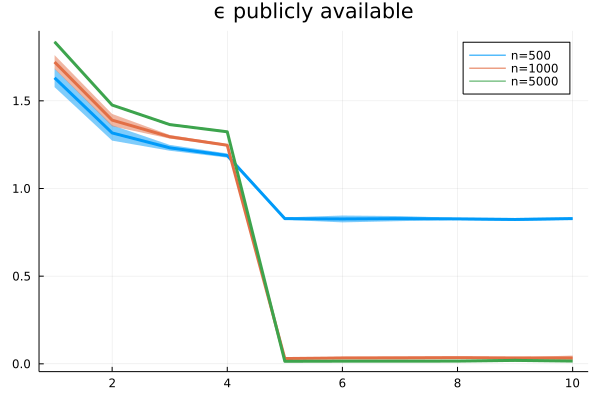

In [65]:
plt1 = plot(title="ϵ publicly available")
for k in eachindex(N)
    plot!(plt1, ϵ,
        map(x -> x == Inf ? missing : x, with_eps[k]) |> eachcol .|> skipmissing .|> median,
        ribbon=map(x -> x == Inf ? missing : x, with_eps[k]) |> eachcol .|> skipmissing .|> mad,
        label="n=$(N[k])",
        lw=3, fillapha=0.01,
    )
end
plt1

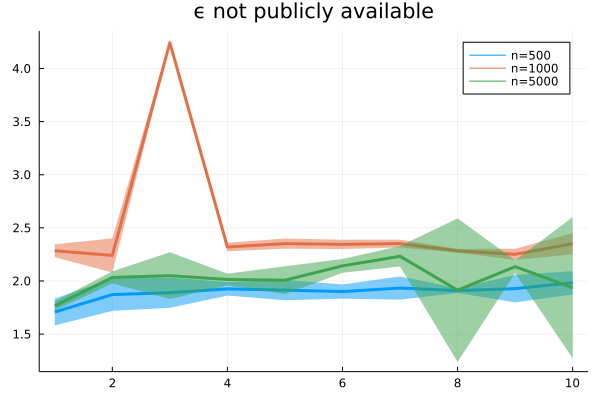

In [68]:
plt2 = plot(title="ϵ not publicly available")
for k in eachindex(N)
    plot!(plt2, ϵ,
        map(x -> x == Inf ? missing : x, without_eps[k]) |> eachcol .|> skipmissing .|> mean,
        ribbon=map(x -> x == Inf ? missing : x, without_eps[k]) |> eachcol .|> skipmissing .|> mad,        # ribbon = 0.5 .* with_eps[k] |> eachcol .|> mad,
        label="n=$(N[k])",
        lw=3, fillapha=0.01,
    )
end
plt2

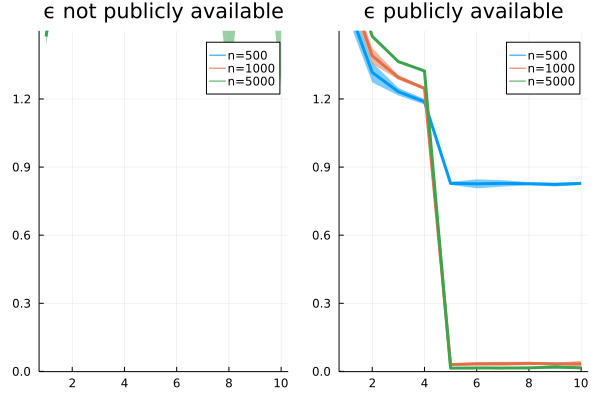

In [67]:
lim=(-1e-3, 1.5); plot(plot(plt2, ylim=lim), plot(plt1, ylim=lim))